## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [37]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [38]:
train, test = keras.datasets.cifar10.load_data()

In [39]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [40]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [79]:
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.regularizers import l2

"""
建立神經網路，並加入 dropout layer
"""
def build_mlp1(input_shape, output_units=10, num_neurons=[128, 128, 128, 128], drp_ratio=0.2):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, kernel_initializer='random_uniform',
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = Dropout(drp_ratio)(x)
        else:
            x = keras.layers.Dense(units=n_units, kernel_initializer='random_uniform',
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = Dropout(drp_ratio)(x)
    
    out = keras.layers.Dense(units=output_units, kernel_initializer='random_uniform', activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, kernel_initializer='random_uniform',
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, kernel_initializer='random_uniform',
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, kernel_initializer='random_uniform', activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

def build_mlp3(input_shape, output_units=10, num_neurons=[128, 128, 128, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [95]:
LEARNING_RATE = 1e-3
EPOCHS = 30
dic={"BATCH_SIZES" : [32,128,256], "DropOut_rate":[0.25, 0.5], "Regularization":[1e-4, 3e-4]}
# ,  
MOMENTUM = 0.95

In [96]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for method, ls in dic.items():
    for value in ls:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        BATCH_SIZE = 128
        print(f"{method} = {value}")
        if method == "DropOut_rate":
            print("I'm here")
            model = build_mlp1(input_shape=x_train.shape[1:], drp_ratio=value)
        elif method == "BATCH_SIZES":
            model = build_mlp2(input_shape=x_train.shape[1:])
            BATCH_SIZE = value
        elif method == "Regularization":
            model = build_mlp3(input_shape=x_train.shape[1:], l2_ratio=value)
        model.summary()
        optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test))

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        name_tag = f"{key}_{value}"
        results[name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

BATCH_SIZES = 32
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512 

Epoch 9/30
50000/50000 [==============================] - 13s 264us/step - loss: 1.0868 - acc: 0.6113 - val_loss: 1.4480 - val_acc: 0.4954
Epoch 10/30
50000/50000 [==============================] - 14s 289us/step - loss: 1.0536 - acc: 0.6236 - val_loss: 1.5346 - val_acc: 0.4800
Epoch 11/30
50000/50000 [==============================] - 13s 269us/step - loss: 1.0219 - acc: 0.6354 - val_loss: 1.5001 - val_acc: 0.4705
Epoch 12/30
50000/50000 [==============================] - 13s 268us/step - loss: 0.9905 - acc: 0.6467 - val_loss: 1.5101 - val_acc: 0.4989
Epoch 13/30
50000/50000 [==============================] - 13s 264us/step - loss: 0.9617 - acc: 0.6563 - val_loss: 1.4112 - val_acc: 0.5188
Epoch 14/30
50000/50000 [==============================] - 13s 254us/step - loss: 0.9294 - acc: 0.6683 - val_loss: 1.4906 - val_acc: 0.4949
Epoch 15/30
50000/50000 [==============================] - 13s 258us/step - loss: 0.9089 - acc: 0.6743 - val_loss: 1.4579 - val_acc: 0.5059
Epoch 16/30
50000/500

50000/50000 [==============================] - 9s 182us/step - loss: 0.5617 - acc: 0.7974 - val_loss: 1.8758 - val_acc: 0.4839
Epoch 27/30
50000/50000 [==============================] - 10s 194us/step - loss: 0.5430 - acc: 0.8043 - val_loss: 1.9294 - val_acc: 0.4810
Epoch 28/30
50000/50000 [==============================] - 9s 178us/step - loss: 0.5167 - acc: 0.8159 - val_loss: 2.0569 - val_acc: 0.4794
Epoch 29/30
50000/50000 [==============================] - 10s 200us/step - loss: 0.5003 - acc: 0.8189 - val_loss: 1.8574 - val_acc: 0.5087
Epoch 30/30
50000/50000 [==============================] - 9s 181us/step - loss: 0.4771 - acc: 0.8274 - val_loss: 2.2406 - val_acc: 0.4722
DropOut_rate = 0.25
I'm here
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense) 

Train on 50000 samples, validate on 10000 samples
Epoch 1/30
50000/50000 [==============================] - 6s 111us/step - loss: 2.1659 - acc: 0.1559 - val_loss: 2.0652 - val_acc: 0.1934
Epoch 2/30
50000/50000 [==============================] - 5s 104us/step - loss: 2.0806 - acc: 0.1897 - val_loss: 2.0784 - val_acc: 0.2087
Epoch 3/30
50000/50000 [==============================] - 5s 102us/step - loss: 2.0714 - acc: 0.1932 - val_loss: 2.0533 - val_acc: 0.2368
Epoch 4/30
50000/50000 [==============================] - 5s 102us/step - loss: 2.0477 - acc: 0.2049 - val_loss: 1.9884 - val_acc: 0.2420
Epoch 5/30
50000/50000 [==============================] - 5s 102us/step - loss: 2.0418 - acc: 0.2069 - val_loss: 2.0502 - val_acc: 0.2240
Epoch 6/30
50000/50000 [==============================] - 5s 101us/step - loss: 2.0330 - acc: 0.2131 - val_loss: 2.0112 - val_acc: 0.2493
Epoch 7/30
50000/50000 [==============================] - 5s 101us/step - loss: 2.0201 - acc: 0.2176 - val_loss: 2.0195 - 

50000/50000 [==============================] - 5s 102us/step - loss: 1.2725 - acc: 0.5665 - val_loss: 1.4704 - val_acc: 0.4973
Epoch 21/30
50000/50000 [==============================] - 5s 101us/step - loss: 1.2772 - acc: 0.5667 - val_loss: 1.4971 - val_acc: 0.4873
Epoch 22/30
50000/50000 [==============================] - 5s 101us/step - loss: 1.2533 - acc: 0.5727 - val_loss: 1.4747 - val_acc: 0.5071
Epoch 23/30
50000/50000 [==============================] - 5s 105us/step - loss: 1.2488 - acc: 0.5780 - val_loss: 1.4789 - val_acc: 0.5029
Epoch 24/30
50000/50000 [==============================] - 5s 103us/step - loss: 1.2343 - acc: 0.5834 - val_loss: 1.4925 - val_acc: 0.5066
Epoch 25/30
50000/50000 [==============================] - 5s 109us/step - loss: 1.2298 - acc: 0.5831 - val_loss: 1.4569 - val_acc: 0.5136
Epoch 26/30
50000/50000 [==============================] - 6s 112us/step - loss: 1.2185 - acc: 0.5875 - val_loss: 1.4588 - val_acc: 0.5213
Epoch 27/30
50000/50000 [==============

IndexError: list index out of range

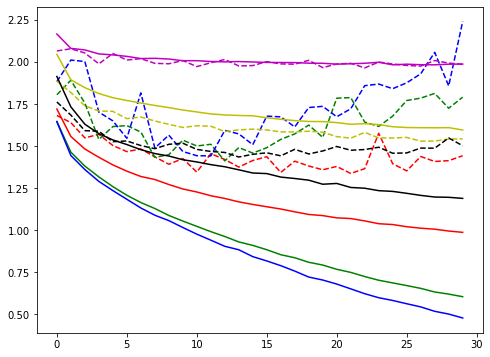

In [97]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()